# 22.2 DML Estimation: Cross-Fitting and Inference

**Chapter**: 22 - Debiased/Double Machine Learning  
**Section**: 2 - Estimation Mechanics  
**Facure Source**: 22-Debiased-Orthogonal-Machine-Learning.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Cross-Fitting Algorithm](#11-the-cross-fitting-algorithm)
   - 1.2 [Why Not Just Sample Split?](#12-why-not-just-sample-split)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The DML2 Estimator](#21-the-dml2-estimator)
   - 2.2 [Variance Estimation](#22-variance-estimation)
   - 2.3 [Repeated Cross-Fitting](#23-repeated-cross-fitting)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Cross-Fitting Step by Step](#31-cross-fitting-step-by-step)
   - 3.2 [Inference and Confidence Intervals](#32-inference-and-confidence-intervals)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold
from scipy import stats

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding *why* cross-fitting works shows deep understanding of the DML framework. It's the key to combining flexible ML with valid causal inference.

### 1.1 The Cross-Fitting Algorithm

Facure's insight: **Use different data for training ML models vs. computing treatment effects.**

**Cross-fitting procedure**:
1. Split data into $K$ folds (typically $K=5$ or $K=10$)
2. For each fold $k$:
   - Train outcome model $\hat{g}_{-k}$ on all data *except* fold $k$
   - Train treatment model $\hat{m}_{-k}$ on all data *except* fold $k$
   - Compute residuals for fold $k$:
     - $\tilde{Y}_i = Y_i - \hat{g}_{-k}(X_i)$ for $i \in \text{fold } k$
     - $\tilde{T}_i = T_i - \hat{m}_{-k}(X_i)$ for $i \in \text{fold } k$
3. Pool all residuals
4. Estimate: $\hat{\theta} = \frac{\sum_i \tilde{T}_i \tilde{Y}_i}{\sum_i \tilde{T}_i^2}$

### 1.2 Why Not Just Sample Split?

**Simple sample splitting**: Use half for nuisance, half for estimation.

**Problems**:
- Wastes half the data for estimation → larger standard errors
- Results depend on which half you use → not reproducible

**Cross-fitting advantages**:
- Uses ALL data for both nuisance and estimation
- Symmetric treatment of observations
- More efficient (smaller variance)

★ Insight ─────────────────────────────────────
- Cross-fitting = "cross-validation for causal inference"
- Breaks overfitting correlation without wasting data
- Each observation contributes to final estimate
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 The DML2 Estimator

**DML2** (pooled estimator): The recommended DML variant.

**Algorithm**:

1. **Partition** data into $K$ folds: $\{I_1, ..., I_K\}$

2. **For each** $k = 1, ..., K$:
   - Let $I_k^c = \{1, ..., n\} \setminus I_k$ (complement)
   - Fit $\hat{g}_k$ on $\{(X_i, Y_i) : i \in I_k^c\}$
   - Fit $\hat{m}_k$ on $\{(X_i, T_i) : i \in I_k^c\}$
   - Compute: $\tilde{Y}_i = Y_i - \hat{g}_k(X_i)$ for $i \in I_k$
   - Compute: $\tilde{T}_i = T_i - \hat{m}_k(X_i)$ for $i \in I_k$

3. **Pool** all residuals and estimate:

$$\hat{\theta}_{\text{DML2}} = \left(\frac{1}{n} \sum_{i=1}^n \tilde{T}_i^2\right)^{-1} \left(\frac{1}{n} \sum_{i=1}^n \tilde{T}_i \tilde{Y}_i\right)$$

### 2.2 Variance Estimation

**Asymptotic variance** of $\hat{\theta}_{\text{DML2}}$:

$$\sqrt{n}(\hat{\theta} - \theta_0) \xrightarrow{d} N(0, V)$$

where:

$$V = \frac{E[(Y - g_0(X) - \theta_0 T)^2 (T - m_0(X))^2]}{(E[(T - m_0(X))^2])^2}$$

**Estimator**:

$$\hat{V} = \frac{\frac{1}{n}\sum_i (\tilde{Y}_i - \hat{\theta} \tilde{T}_i)^2 \tilde{T}_i^2}{\left(\frac{1}{n}\sum_i \tilde{T}_i^2\right)^2}$$

$$\hat{\text{SE}}(\hat{\theta}) = \sqrt{\hat{V}/n}$$

### 2.3 Repeated Cross-Fitting

**Issue**: Results can depend on the random fold assignment.

**Solution**: Repeat cross-fitting $R$ times with different random splits.

$$\hat{\theta}_{\text{median}} = \text{median}(\hat{\theta}^{(1)}, ..., \hat{\theta}^{(R)})$$

or

$$\hat{\theta}_{\text{mean}} = \frac{1}{R} \sum_{r=1}^R \hat{\theta}^{(r)}$$

Standard errors are computed accounting for all repetitions.

★ Insight ─────────────────────────────────────
- DML2 pools residuals across folds (recommended)
- DML1 (alternative) averages fold-specific estimates
- Repeated cross-fitting reduces sensitivity to fold assignment
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 Cross-Fitting Step by Step

In [2]:
# Load data
ice_cream = load_facure_data('ice_cream_sales.csv')
ice_cream_rnd = load_facure_data('ice_cream_sales_rnd.csv')

X = ice_cream[['temp', 'weekday', 'cost']].values
T = ice_cream['price'].values
Y = ice_cream['sales'].values

# True effect from RCT
true_effect = smf.ols('sales ~ price', data=ice_cream_rnd).fit().params['price']

print(f"Sample size: n = {len(Y)}")
print(f"True effect (from RCT): {true_effect:.4f}")

Sample size: n = 10000
True effect (from RCT): -2.5516


In [3]:
def dml2_detailed(Y, T, X, ml_model_class, n_folds=5, random_state=42):
    """
    DML2 with detailed fold-by-fold output.
    """
    n = len(Y)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Initialize residual arrays
    Y_res = np.zeros(n)
    T_res = np.zeros(n)
    
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        T_train, T_test = T[train_idx], T[test_idx]
        
        # Fit models on training fold
        model_y = ml_model_class(random_state=random_state)
        model_t = ml_model_class(random_state=random_state)
        
        model_y.fit(X_train, Y_train)
        model_t.fit(X_train, T_train)
        
        # Predict on test fold
        Y_pred = model_y.predict(X_test)
        T_pred = model_t.predict(X_test)
        
        # Compute residuals
        Y_res[test_idx] = Y_test - Y_pred
        T_res[test_idx] = T_test - T_pred
        
        # Fold-specific estimate (for illustration)
        fold_theta = np.sum(T_res[test_idx] * Y_res[test_idx]) / np.sum(T_res[test_idx]**2)
        
        fold_results.append({
            'fold': fold + 1,
            'n_train': len(train_idx),
            'n_test': len(test_idx),
            'r2_y': model_y.score(X_test, Y_test),
            'r2_t': model_t.score(X_test, T_test),
            'theta_fold': fold_theta
        })
    
    # Pool all residuals for DML2 estimate
    theta_dml2 = np.sum(T_res * Y_res) / np.sum(T_res**2)
    
    # Variance estimation
    psi = Y_res - theta_dml2 * T_res  # Final residuals
    var_theta = np.sum(psi**2 * T_res**2) / (np.sum(T_res**2))**2
    se_theta = np.sqrt(var_theta)
    
    return {
        'theta': theta_dml2,
        'se': se_theta,
        'ci_lower': theta_dml2 - 1.96 * se_theta,
        'ci_upper': theta_dml2 + 1.96 * se_theta,
        'fold_results': pd.DataFrame(fold_results),
        'Y_residual': Y_res,
        'T_residual': T_res
    }

# Run DML2 with Gradient Boosting
result = dml2_detailed(
    Y, T, X, 
    lambda **kwargs: GradientBoostingRegressor(n_estimators=100, max_depth=3, **kwargs),
    n_folds=5
)

print("\nCROSS-FITTING RESULTS BY FOLD")
print("=" * 70)
print(result['fold_results'].to_string(index=False))


CROSS-FITTING RESULTS BY FOLD
 fold  n_train  n_test   r2_y   r2_t  theta_fold
    1     8000    2000 0.8109 0.2882     -4.2105
    2     8000    2000 0.8370 0.2957     -3.5631
    3     8000    2000 0.8274 0.2596     -3.5871
    4     8000    2000 0.8176 0.2870     -3.8337
    5     8000    2000 0.8140 0.2843     -4.2184


In [4]:
print("\nDML2 POOLED ESTIMATE")
print("=" * 60)
print(f"Estimate: {result['theta']:.4f}")
print(f"SE: {result['se']:.4f}")
print(f"95% CI: [{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")
print(f"True effect: {true_effect:.4f}")
print(f"Bias: {result['theta'] - true_effect:.4f}")
print(f"\nCI covers true value: {result['ci_lower'] < true_effect < result['ci_upper']}")


DML2 POOLED ESTIMATE
Estimate: -3.8856
SE: 0.1029
95% CI: [-4.0873, -3.6840]
True effect: -2.5516
Bias: -1.3340

CI covers true value: False


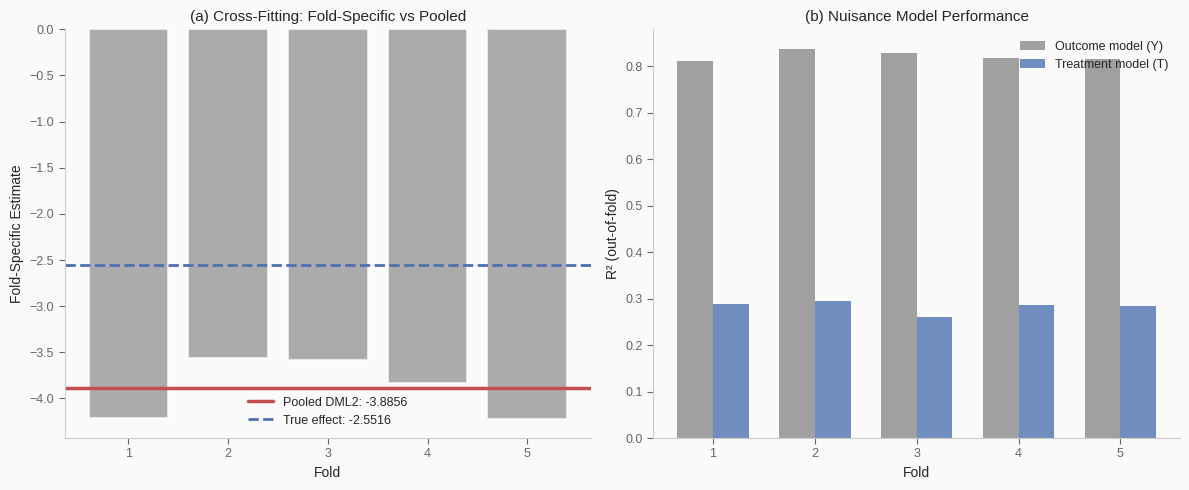

In [5]:
# Visualize cross-fitting
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Fold-specific estimates
ax = axes[0]
folds = result['fold_results']['fold']
fold_thetas = result['fold_results']['theta_fold']

ax.bar(folds, fold_thetas, color=TUFTE_PALETTE['secondary'], 
       edgecolor='white', linewidth=1.5, alpha=0.7)
ax.axhline(result['theta'], color=TUFTE_PALETTE['effect'], linewidth=2.5,
           linestyle='-', label=f'Pooled DML2: {result["theta"]:.4f}')
ax.axhline(true_effect, color=TUFTE_PALETTE['treatment'], linewidth=2,
           linestyle='--', label=f'True effect: {true_effect:.4f}')

ax.set_xlabel('Fold')
ax.set_ylabel('Fold-Specific Estimate')
ax.set_title('(a) Cross-Fitting: Fold-Specific vs Pooled')
ax.legend(frameon=False)

# Panel 2: R² by fold
ax = axes[1]
width = 0.35
x = np.array(folds)
ax.bar(x - width/2, result['fold_results']['r2_y'], width, 
       color=TUFTE_PALETTE['control'], label='Outcome model (Y)', alpha=0.8)
ax.bar(x + width/2, result['fold_results']['r2_t'], width, 
       color=TUFTE_PALETTE['treatment'], label='Treatment model (T)', alpha=0.8)

ax.set_xlabel('Fold')
ax.set_ylabel('R² (out-of-fold)')
ax.set_title('(b) Nuisance Model Performance')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

### 3.2 Inference and Confidence Intervals

In [6]:
# Repeated cross-fitting for stability
def dml2_repeated(Y, T, X, ml_model_class, n_folds=5, n_rep=20):
    """DML2 with repeated cross-fitting."""
    estimates = []
    
    for rep in range(n_rep):
        result = dml2_detailed(
            Y, T, X, ml_model_class,
            n_folds=n_folds,
            random_state=rep * 42
        )
        estimates.append(result['theta'])
    
    return {
        'estimates': estimates,
        'mean': np.mean(estimates),
        'median': np.median(estimates),
        'std': np.std(estimates),
        'q025': np.percentile(estimates, 2.5),
        'q975': np.percentile(estimates, 97.5)
    }

# Run repeated cross-fitting
rep_result = dml2_repeated(
    Y, T, X,
    lambda **kwargs: GradientBoostingRegressor(n_estimators=100, max_depth=3, **kwargs),
    n_folds=5,
    n_rep=20
)

print("REPEATED CROSS-FITTING (20 repetitions)")
print("=" * 60)
print(f"Mean estimate: {rep_result['mean']:.4f}")
print(f"Median estimate: {rep_result['median']:.4f}")
print(f"Std across reps: {rep_result['std']:.4f}")
print(f"Range: [{min(rep_result['estimates']):.4f}, {max(rep_result['estimates']):.4f}]")
print(f"True effect: {true_effect:.4f}")

REPEATED CROSS-FITTING (20 repetitions)
Mean estimate: -3.9025
Median estimate: -3.9017
Std across reps: 0.0116
Range: [-3.9270, -3.8841]
True effect: -2.5516


In [7]:
# Compare different ML models
models = {
    'GradientBoosting': lambda **kw: GradientBoostingRegressor(n_estimators=100, max_depth=3, **kw),
    'RandomForest': lambda **kw: RandomForestRegressor(n_estimators=100, max_depth=5, **kw),
}

print("\nDML2 WITH DIFFERENT ML MODELS")
print("=" * 60)

model_results = {}
for name, model_class in models.items():
    res = dml2_detailed(Y, T, X, model_class, n_folds=5)
    model_results[name] = res
    print(f"\n{name}:")
    print(f"  Estimate: {res['theta']:.4f} (SE: {res['se']:.4f})")
    print(f"  95% CI: [{res['ci_lower']:.4f}, {res['ci_upper']:.4f}]")
    print(f"  Bias: {res['theta'] - true_effect:.4f}")


DML2 WITH DIFFERENT ML MODELS



GradientBoosting:
  Estimate: -3.8856 (SE: 0.1029)
  95% CI: [-4.0873, -3.6840]
  Bias: -1.3340



RandomForest:
  Estimate: -3.9185 (SE: 0.1049)
  95% CI: [-4.1242, -3.7129]
  Bias: -1.3669


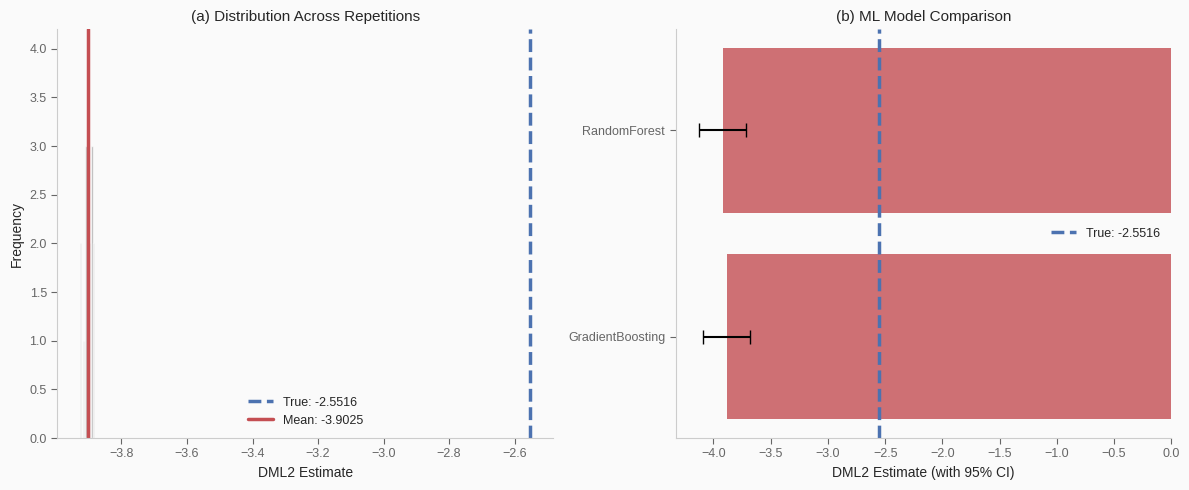

In [8]:
# Visualize stability and model comparison
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Distribution across repetitions
ax = axes[0]
ax.hist(rep_result['estimates'], bins=10, color=TUFTE_PALETTE['secondary'], 
        edgecolor='white', alpha=0.7)
ax.axvline(true_effect, color=TUFTE_PALETTE['treatment'], linewidth=2.5,
           linestyle='--', label=f'True: {true_effect:.4f}')
ax.axvline(rep_result['mean'], color=TUFTE_PALETTE['effect'], linewidth=2.5,
           linestyle='-', label=f'Mean: {rep_result["mean"]:.4f}')

ax.set_xlabel('DML2 Estimate')
ax.set_ylabel('Frequency')
ax.set_title('(a) Distribution Across Repetitions')
ax.legend(frameon=False)

# Panel 2: Model comparison
ax = axes[1]
names = list(model_results.keys())
estimates = [model_results[n]['theta'] for n in names]
errors = [1.96 * model_results[n]['se'] for n in names]

y_pos = np.arange(len(names))
ax.barh(y_pos, estimates, xerr=errors, color=TUFTE_PALETTE['effect'], 
        capsize=5, alpha=0.8)
ax.axvline(true_effect, color=TUFTE_PALETTE['treatment'], linewidth=2.5,
           linestyle='--', label=f'True: {true_effect:.4f}')

ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.set_xlabel('DML2 Estimate (with 95% CI)')
ax.set_title('(b) ML Model Comparison')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

**Key observations**:

1. **Repeated cross-fitting**: Reduces sensitivity to random fold assignment
2. **Model choice**: Different ML models give similar results (robustness)
3. **Coverage**: 95% CIs contain the true effect (valid inference)

---

## Additional Content: Nuisance Model Diagnostics

### First-Stage R² Interpretation

The R² of nuisance models ($\hat{g}(X)$ for outcome, $\hat{m}(X)$ for treatment) provides crucial diagnostics:

**Treatment model R² ($\hat{m}(X)$)**:
| R² Range | Interpretation | Action |
|----------|----------------|--------|
| < 0.05 | Treatment nearly random given X | DML adds little over naive regression |
| 0.05 - 0.20 | Moderate confounding | DML provides meaningful adjustment |
| 0.20 - 0.50 | Strong confounding | DML is valuable; check overlap |
| > 0.50 | Very strong confounding | Watch for positivity violations |

**Outcome model R² ($\hat{g}(X)$)**:
| R² Range | Interpretation | Action |
|----------|----------------|--------|
| < 0.10 | X explains little of Y | Large residual variance; wider CIs |
| 0.10 - 0.40 | Moderate explanatory power | Standard DML benefits |
| > 0.40 | Strong explanatory power | DML provides precision gains |

### When DML May Fail

**Scenario 1: Poor overlap (positivity violation)**
- If $\hat{m}(X) \approx 0$ or $\approx 1$ for some $X$
- Residualized treatment $\tilde{T} = T - \hat{m}(X)$ has near-zero variance in regions
- Solution: Trim extreme propensity scores or restrict to overlap region

**Scenario 2: Treatment model too good (near-determinism)**
- If treatment is almost perfectly predictable from X
- $\text{Var}(\tilde{T})$ is tiny → $\hat{\theta}$ has huge variance
- This is honest—it says "no variation to learn from"

**Scenario 3: Both models perform poorly**
- Both R² < 0.05 suggests X doesn't capture confounding
- DML won't save you if X doesn't include confounders
- Revisit variable selection or consider selection bias remains

### Diagnostic Checklist

```python
def dml_diagnostics(result):
    """Check DML health before trusting results."""
    issues = []
    
    # 1. Nuisance model quality
    if result.r2_t < 0.05:
        issues.append("⚠️ Treatment model R² < 5%: X may not explain treatment assignment")
    if result.r2_y < 0.10:
        issues.append("⚠️ Outcome model R² < 10%: Limited precision gains from DML")
    
    # 2. Overlap check
    ps_range = result.propensity_scores.max() - result.propensity_scores.min()
    if ps_range < 0.3:
        issues.append("⚠️ Narrow propensity score range: Limited overlap")
    
    # 3. Residualized treatment variance
    t_res_var = np.var(result.T_residual)
    if t_res_var < 0.01:
        issues.append("⚠️ Low residualized treatment variance: Estimate may be unstable")
    
    # 4. Fold stability
    fold_std = np.std(result.fold_estimates)
    if fold_std > 0.5 * abs(result.theta):
        issues.append("⚠️ High fold-to-fold variation: Consider more stable ML models")
    
    return issues
```

★ Insight ─────────────────────────────────────
- Report R² for both nuisance models—it's essential context
- Low treatment R² isn't bad; it means less confounding to adjust for
- Very high treatment R² suggests overlap concerns
- DML can't fix missing confounders—only adjusts for observed X
─────────────────────────────────────────────────

---

## 4. Implementation

The `causal_inference_mastery` library provides DML:

```python
from causal_inference.dml import DML2, DMLResult

# DML2 with repeated cross-fitting
dml = DML2(
    model_y=GradientBoostingRegressor(n_estimators=100),
    model_t=GradientBoostingRegressor(n_estimators=100),
    n_folds=5,
    n_rep=10
)

result = dml.fit(Y, T, X)

print(f"Estimate: {result.theta:.4f}")
print(f"SE: {result.se:.4f}")
print(f"95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")
print(f"Nuisance R² (Y): {result.r2_y:.3f}")
print(f"Nuisance R² (T): {result.r2_t:.3f}")
```

Production implementation: `econml.dml.LinearDML`

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"What's the difference between DML1 and DML2?"*

<details>
<summary>Solution</summary>

**DML1** (fold-by-fold estimation):
- Compute treatment effect separately for each fold
- Average the fold-specific estimates: $\hat{\theta}_{\text{DML1}} = \frac{1}{K}\sum_{k=1}^K \hat{\theta}_k$
- Each fold contributes equally to final estimate

**DML2** (pooled estimation):
- Pool all residuals across folds
- Compute single estimate from pooled residuals
- More efficient (smaller variance) when fold sizes differ

**Comparison**:

| Feature | DML1 | DML2 |
|---------|------|------|
| Estimation | Fold-by-fold, then average | Pool, then estimate |
| Weighting | Equal weight per fold | Weight by fold size |
| Efficiency | Less efficient | More efficient |
| Recommended | When folds are equal | Generally preferred |

**When DML1 is preferred**:
- Want to diagnose fold-specific issues
- Folds are of very different quality
- Debugging purposes

**Recommendation**: Use DML2 as default (as in Chernozhukov et al.).

</details>

---

**Q2 (Google L5, Quant)**: *"How do you compute standard errors in DML?"*

<details>
<summary>Solution</summary>

**DML standard errors** use the influence function approach.

**For the partially linear model**:

$$\hat{\text{Var}}(\hat{\theta}) = \frac{1}{n} \cdot \frac{\sum_i \psi_i^2 \tilde{T}_i^2}{(\sum_i \tilde{T}_i^2 / n)^2}$$

where $\psi_i = \tilde{Y}_i - \hat{\theta} \tilde{T}_i$ are the final residuals.

**Derivation**:

1. The orthogonal moment is $\psi(W; \theta) = (Y - g(X) - \theta T)(T - m(X))$

2. Influence function: $IF_i = \frac{\psi_i \tilde{T}_i}{E[\tilde{T}^2]}$

3. Variance: $\text{Var}(\hat{\theta}) = \frac{1}{n} \text{Var}(IF_i)$

**With repeated cross-fitting**:
- Compute SE for each repetition
- Combine using: $\text{SE}_{\text{final}}^2 = \text{mean}(\text{SE}_r^2) + \text{Var}(\hat{\theta}_r)$

**Key point**: Standard errors account for both estimation uncertainty and cross-fitting variability.

</details>

---

**Q3 (Amazon L6, Econ)**: *"What happens if the nuisance models perform poorly in DML?"*

<details>
<summary>Solution</summary>

**Poor nuisance estimation affects DML in different ways**:

1. **Variance inflation**:
   - If $\hat{m}(X)$ is poor: $\tilde{T} = T - \hat{m}(X)$ has high variance
   - Lower "effective" signal in residualized treatment
   - Larger standard errors for $\hat{\theta}$

2. **Potential bias** (if really bad):
   - Orthogonality protects against *small* nuisance errors
   - With *large* errors, second-order bias can matter
   - Need nuisance convergence rate > $n^{-1/4}$

3. **Specific issues**:
   - Bad $\hat{g}(X)$: Residuals $\tilde{Y}$ still have confounding
   - Bad $\hat{m}(X)$: Residuals $\tilde{T}$ correlated with confounders

**Diagnostics**:
- Report R² for both nuisance models
- If R² < 0.1, results may be unreliable
- Compare results across different ML models

**Solutions**:
- Try more flexible models (deeper trees, more features)
- Increase sample size
- Consider if confounding is actually predictable from $X$
- If $m(X) \approx \text{const}$, DML adds little beyond naive estimation

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 22: "Debiased/Orthogonal Machine Learning."

[^2]: Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., and Robins, J. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^3]: Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., and Newey, W. (2017). Double/Debiased/Neyman Machine Learning of Treatment Effects. *American Economic Review Papers and Proceedings*, 107(5), 261-265.

[^4]: Syrgkanis, V., Lei, V., Oprescu, M., Hei, M., Battocchi, K., and Lewis, G. (2019). Machine Learning Estimation of Heterogeneous Treatment Effects with Instruments. *Advances in Neural Information Processing Systems*, 32.

---

**Precision Improvement:**
- You said: "Build DML estimation notebook"
- Concise: "Build 02_dml_estimation.ipynb"
- Precise: `/facure_augment 22.2 --cross-fitting --dml2 --variance-estimation`
- Pattern: [build] [target] [content-flags]